# Exploratory Data Analysis

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.sparse import hstack, csr_matrix
import sys
import os
import re
import swifter
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset as TorchDataset, DataLoader
from datasets import load_dataset, Dataset as HFDataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline, EarlyStoppingCallback
from evaluate import load
import shap
warnings.filterwarnings('ignore')

# Add the root project directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_raw_data #importing data loader
from src.load_glove_embedding import load_glove_embeddings # importing glove embeddings

# Setup
#sns.set(style = "whitegrid")

c:\Users\Lenny\Downloads\movie-review-sentiment-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading NLTK

In [2]:
nltk_path = os.path.join(project_root, 'nltk_data')
nltk.data.path.insert(0, nltk_path)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# quick test
text = "This is a test sentence."
tokens = nltk.word_tokenize(text)
print(tokens)

['This', 'is', 'a', 'test', 'sentence', '.']


In [3]:
# Get device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Loading the dataset

In [4]:
# Load the dataset
text_df = load_raw_data()

# Preview
text_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

### General Overview

Dataset shape: (50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


<Axes: title={'center': 'Class Balance'}, xlabel='sentiment'>

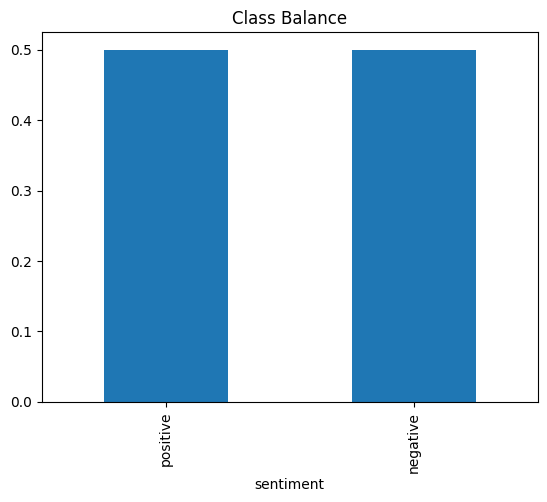

In [5]:
# Basic info
print(f"Dataset shape: {text_df.shape}")
print(text_df.info())
text_df["sentiment"].value_counts(normalize=True).plot(kind="bar", title="Class Balance")

This is a balanced dataset with no missing values. 

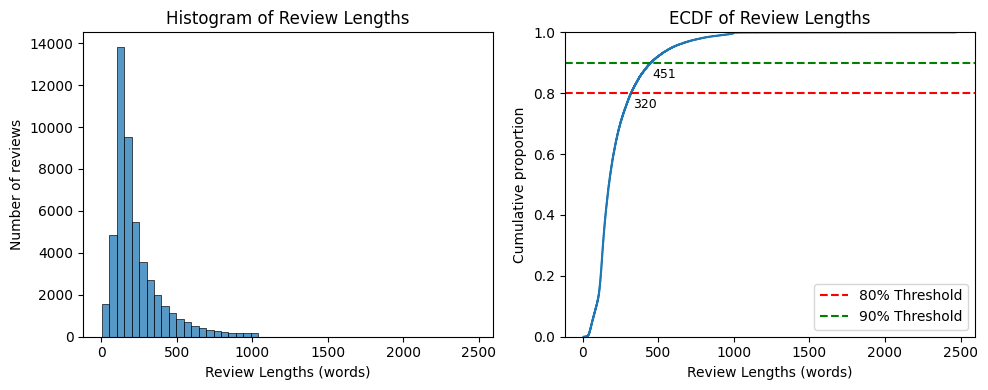

In [6]:
# Adding a column for review length
fig, axes = plt.subplots(1, 2, figsize=(10,4))
text_df["review_length"] = text_df["review"].apply(lambda x: len(str(x).split()))

# histogram of reviews lengths
sns.histplot(text_df["review_length"], bins=50, ax=axes[0])
axes[0].set_title("Histogram of Review Lengths")
axes[0].set_xlabel("Review Lengths (words)")
axes[0].set_ylabel("Number of reviews")

# ECDF plot of review lengths
sns.ecdfplot(data = text_df, x = "review_length", ax=axes[1])
axes[1].set_title("ECDF of Review Lengths")
axes[1].set_xlabel("Review Lengths (words)")
axes[1].set_ylabel("Cumulative proportion")
axes[1].axhline(y=0.8, color="red", linestyle="--", label="80% Threshold")
axes[1].axhline(y=0.9, color="green", linestyle="--", label="90% Threshold")
x_80 = text_df["review_length"].quantile(0.8)
x_90 = text_df["review_length"].quantile(0.9)
axes[1].legend()
# annotating the 80th percentile
axes[1].annotate(f'{x_80:.0f}',
                 xy=(x_80, 0.8),
                 xytext=(x_80 + 10, 0.75),
                 fontsize=9)
# annotating the 90th percentile
axes[1].annotate(f'{x_90:.0f}',
                 xy=(x_90, 0.9),
                 xytext=(x_90 + 10, 0.85),
                 fontsize=9)

plt.tight_layout()
plt.show()

In [7]:
text_df.describe().T.style.set_caption("Descriptive Statistics").format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
review_length,50000.00,231.16,171.34,4.00,126.00,173.00,280.00,2470.00


In [8]:
# checking for duplicates
text_df.nunique()

review           49582
sentiment            2
review_length     1047
dtype: int64

### Data Integrity Checks

In [9]:
text_df.isnull().sum()

review           0
sentiment        0
review_length    0
dtype: int64

In [10]:
text_df["review"].duplicated().sum()

np.int64(418)

Duplicates need to be dropped at some point

In [11]:
text_df[text_df.duplicated() == True]

,review,sentiment,review_length
3537,Quite what the producers of this appalling ada...,negative,401
3769,My favourite police series of all time turns t...,positive,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,110
6352,If you liked the Grinch movie... go watch that...,negative,100
6479,I want very much to believe that the above quo...,negative,446
...,...,...,...
49912,This is an incredible piece of drama and power...,positive,170
49950,This was a very brief episode that appeared in...,negative,199
49984,Hello it is I Derrick Cannon and I welcome you...,negative,417
49986,This movie is a disgrace to the Major League F...,negative,118


In [12]:
text_df_no_duplicates = text_df.drop_duplicates(subset = ["review"],
                                                keep="first")
text_df_no_duplicates.shape

(49582, 3)

### Numeric Features

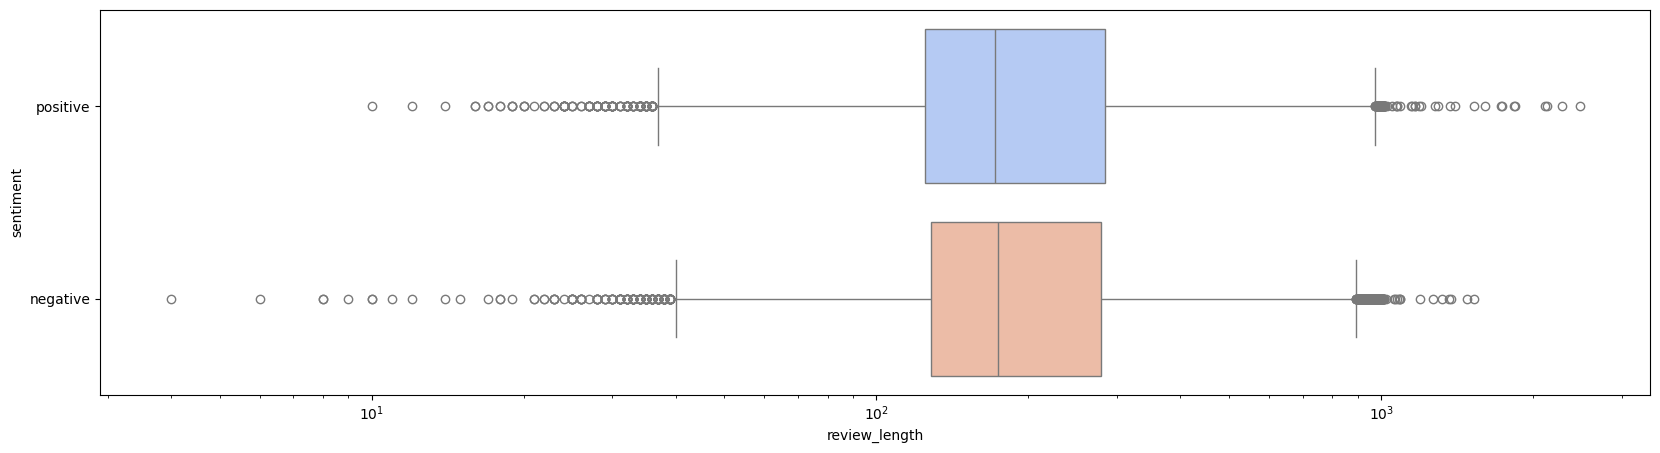

In [13]:
plt.figure(figsize = (20,5))
sns.boxplot(
    data = text_df_no_duplicates,
    x = text_df["review_length"],
    y = text_df["sentiment"],
    palette = "coolwarm",
    log_scale = True
)
plt.show()

### Text features

In [14]:
text_df_no_duplicates.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


text has html tags

In [15]:
#define clean_text
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                   # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", " ", text)          # Remove URLs
    text = re.sub(r"[^\x00-\x7F]+", " ", text)           # Remove non-ASCII
    text = re.sub(r"[_]+", " ", text)                    # Removes underscores
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation/special chars
    text = re.sub(r"\s+", " ", text)                     # Normalize whitespace
    return text

In [16]:
#test clean_text function
print(clean_text(text_df_no_duplicates.iloc[0, 0]))

One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare Forget pretty 

In [17]:
# adding clean review column
text_df_no_duplicates["clean_review"] = text_df_no_duplicates["review"].apply(lambda x: clean_text(x))

In [18]:
# normalising the text data
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Tokenization
    text = re.sub(r"[^\w\s+]", " ", text)
    tokens = nltk.word_tokenize(text)
    # 3. Stop Word Removal
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # 4. Stemming/Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [19]:
# quick test
print(preprocess_text(text_df_no_duplicates.iloc[0, 0]))
print(text_df_no_duplicates.iloc[0, 3])
text_df_no_duplicates.columns

['one', 'reviewer', 'mentioned', 'watching', '1', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audience', 'forget'

Index(['review', 'sentiment', 'review_length', 'clean_review'], dtype='object')

### Data Transformation

In [20]:
# encoding categorical variables
text_df_no_duplicates["label"] = text_df_no_duplicates["sentiment"].map({"positive" : 1, "negative" : 0})
text_df_no_duplicates["tokenized"] = text_df_no_duplicates["clean_review"].apply(lambda x: preprocess_text(x))

# new data frame with labels and tokens
df = text_df_no_duplicates[["clean_review", "label"]]

# splitting data into training and testing sets
review_train, review_test, label_train, label_test = train_test_split(df["clean_review"], df["label"], test_size=0.2, random_state = 42)
review_token_train, review_token_test, label_train, label_test = train_test_split(text_df_no_duplicates["tokenized"], df["label"], test_size=0.2, random_state = 42)

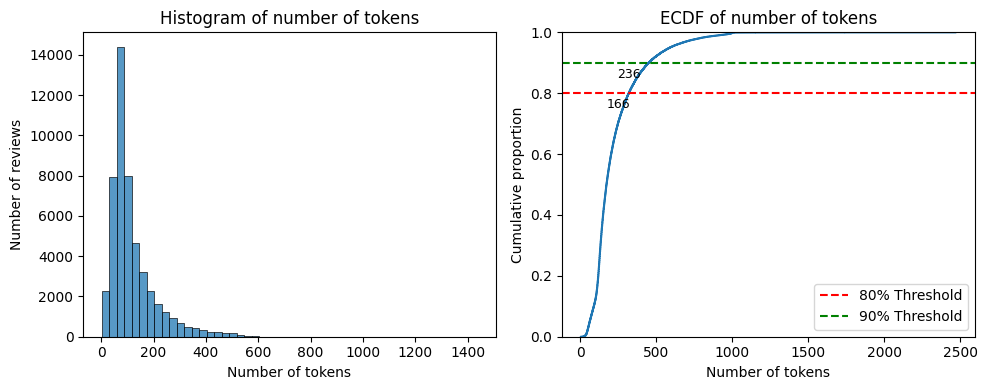

In [21]:
# Adding a column for review length
fig, axes = plt.subplots(1, 2, figsize=(10,4))
text_df_no_duplicates["token_length"] = text_df_no_duplicates["tokenized"].apply(lambda x: len(x))

# histogram of reviews lengths
sns.histplot(text_df_no_duplicates["token_length"], bins=50, ax=axes[0])
axes[0].set_title("Histogram of number of tokens")
axes[0].set_xlabel("Number of tokens")
axes[0].set_ylabel("Number of reviews")

# ECDF plot of review lengths
sns.ecdfplot(data = text_df, x = "review_length", ax=axes[1])
axes[1].set_title("ECDF of number of tokens")
axes[1].set_xlabel("Number of tokens")
axes[1].set_ylabel("Cumulative proportion")
axes[1].axhline(y=0.8, color="red", linestyle="--", label="80% Threshold")
axes[1].axhline(y=0.9, color="green", linestyle="--", label="90% Threshold")
x_80 = text_df_no_duplicates["token_length"].quantile(0.8)
x_90 = text_df_no_duplicates["token_length"].quantile(0.9)
axes[1].legend()
# annotating the 80th percentile
axes[1].annotate(f'{x_80:.0f}',
                 xy=(x_80, 0.8),
                 xytext=(x_80 + 10, 0.75),
                 fontsize=9)
# annotating the 90th percentile
axes[1].annotate(f'{x_90:.0f}',
                 xy=(x_90, 0.9),
                 xytext=(x_90 + 10, 0.85),
                 fontsize=9)

plt.tight_layout()
plt.show()

## Feature extraction

In [22]:
# Create a TfidVectorizer object
vectorizer = TfidfVectorizer(#tokenizer = preprocess_text,
                             #lowercase = False,
                             min_df = 10,
                             ngram_range=(1,3),
                             max_features = 50000,
                             stop_words = "english")

# Fit the vectorizer and tranform the reviews into a TF-IDF representation
train_vectors = vectorizer.fit_transform(review_train)
test_vectors = vectorizer.transform(review_test)

# print TF-IDF matrix shape
print(np.shape(train_vectors))
print(np.shape(test_vectors))

(39665, 50000)
(9917, 50000)


In [23]:
train_vectors[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 71 stored elements and shape (1, 50000)>

In [24]:
# print the vocabulary
print(vectorizer.get_feature_names_out()[:150])

['00' '000' '000 00' '000 000' '000 dollars' '000 years' '007' '01' '02'
 '05' '06' '07' '08' '10' '10 000' '10 10' '10 10 stars' '10 12' '10 15'
 '10 15 minutes' '10 20' '10 acting' '10 best' '10 bethany'
 '10 bethany cox' '10 dir' '10 don' '10 fiend' '10 film' '10 generous'
 '10 good' '10 great' '10 highly' '10 hours' '10 items' '10 just'
 '10 kids' '10 like' '10 line' '10 lines' '10 lines text' '10 lowest'
 '10 million' '10 minute' '10 minutes' '10 minutes film'
 '10 minutes movie' '10 movie' '10 overall' '10 people' '10 points'
 '10 probably' '10 rated' '10 rating' '10 really' '10 recommend'
 '10 second' '10 seconds' '10 simply' '10 star' '10 stars' '10 think'
 '10 times' '10 ve' '10 worst' '10 year' '10 year old' '10 years'
 '10 years ago' '10 years old' '100' '100 000' '100 greatest' '100 imdb'
 '100 imdb 10' '100 list' '100 million' '100 minutes' '100 movies'
 '100 times' '100 years' '1000' '101' '101 dalmatians' '102' '104' '105'
 '105 minutes' '108' '109' '10th' '11' '11 10' '

## Training Model

### Logistic Regression

In [25]:
# Train Logistic Regression model as a baseline
lr = LogisticRegression()
lr.fit(train_vectors, label_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [26]:
# making predictions on the test set
predictions = lr.predict(test_vectors)

In [27]:
# Evaluating the model accuracy and f1 score
accuracy = accuracy_score(label_test, predictions)
f1 = f1_score(label_test, predictions)

print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(label_test, predictions))

Accuracy: 0.8961379449430271
F1: 0.8984220907297831
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4939
           1       0.88      0.92      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



Confusion matrix
[[4332  607]
 [ 423 4555]]


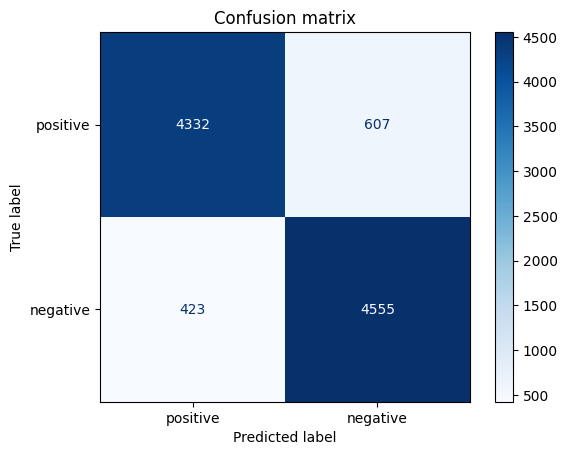

In [28]:
disp = ConfusionMatrixDisplay.from_estimator(
        lr,
        test_vectors,
        label_test,
        display_labels = text_df_no_duplicates.sentiment.unique(),
        cmap = plt.cm.Blues,
    )
disp.ax_.set_title("Confusion matrix")

print("Confusion matrix")
print(disp.confusion_matrix)

plt.show()

### Examining predictions

In [29]:
print(review_test.iloc[0])
print(label_test.iloc[0])

 Soul Plane is a horrible attempt at comedy that only should appeal people with thick skulls bloodshot eyes and furry pawns The plot is not only incoherent but also non existent acting is mostly sub sub par with a gang of highly moronic and dreadful characters thrown in for bad measure jokes are often spotted miles ahead and almost never even a bit amusing This movie lacks any structure and is full of racial stereotypes that must have seemed old even in the fifties the only thing it really has going for it is some pretty ladies but really if you want that you can rent something from the Adult section OK I can hardly see anything here to recommend since you ll probably have a lot a better and productive time chasing rats with a sledgehammer or inventing waterproof teabags or whatever 2 10
0


In [30]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(lr, train_vectors, feature_names=vectorizer.get_feature_names_out())   # Shap Explainer
shap_values = explainer(test_vectors)                # Compute SHAP values

In [31]:
def shapley_plot(index):
    shap.initjs()

    i = index

    # Get top 10 features by absolute SHAP value
    top_indices = np.argsort(np.abs(shap_values[i].values))[-10:]

    return shap.force_plot(
        shap_values[i].base_values,
        shap_values[i].values[top_indices],
        shap_values[i].data[top_indices],
        feature_names=vectorizer.get_feature_names_out()[top_indices]
    )

### Top Global Features 

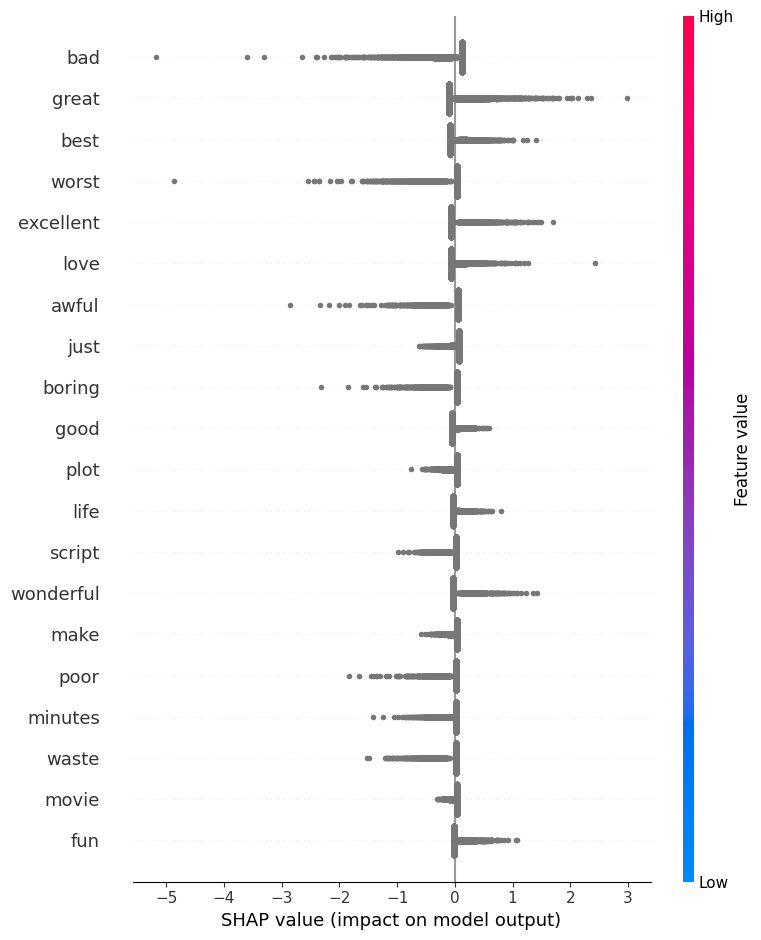

In [32]:
shap.summary_plot(shap_values, test_vectors, feature_names=vectorizer.get_feature_names_out())

### Analyse a wrong prediction

In [33]:
# Error analysis
count = 0

for idx, (pred, label) in enumerate(zip(predictions, label_test)):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(review_test.iloc[idx])
        count += 1
        if count == 5:
            break

Index: 2, Predicted: 1, Actual: 0
 National Treasure 2004 is a thoroughly misguided hodge podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy clich that has ever been written The film stars Nicholas Cage as Benjamin Franklin Gates how precious is that I ask you a seemingly normal fellow who for no other reason than being of a lineage of like minded misguided fortune hunters decides to steal a national treasure that has been hidden by the United States founding fathers After a bit of subtext and background that plays laughably unintentionally like Indiana Jones meets The Patriot the film degenerates into one misguided whimsy after another attempting to create a Stanley Goodspeed regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane but disconnected misadventures The relevancy and logic to having George Washington and his motley crew of patriots burying a king s ransom someplace on native soil

#### False positive

In [34]:
print(review_test.iloc[2])
print(f"Predicted: {predictions[2]}, Actual: {label_test.iloc[2]}")
shapley_plot(2)

 National Treasure 2004 is a thoroughly misguided hodge podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy clich that has ever been written The film stars Nicholas Cage as Benjamin Franklin Gates how precious is that I ask you a seemingly normal fellow who for no other reason than being of a lineage of like minded misguided fortune hunters decides to steal a national treasure that has been hidden by the United States founding fathers After a bit of subtext and background that plays laughably unintentionally like Indiana Jones meets The Patriot the film degenerates into one misguided whimsy after another attempting to create a Stanley Goodspeed regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane but disconnected misadventures The relevancy and logic to having George Washington and his motley crew of patriots burying a king s ransom someplace on native soil and then going through the meticu

#### False Negative

In [35]:
print(review_test.iloc[22])
print(f"Predicted: {predictions[22]}, Actual: {label_test.iloc[22]}")
shapley_plot(22)

A horror movie is being shot and things aren t going well It s about a masked killer The director tells off the killer in front of the cast and crew He goes crazy and kills two people He s killed himself and the film is never finished Twelve years later a bunch of film students decide to try and finish it but there s a curse People who try and finish it are killed themselves The students ignore that Guess what happens next The plot is old hat but this isn t bad for what it is a low budget slasher film It s well made with a young and fairly talented young cast No one is great but no one is terrible either It also avoids the obligatory and needless female nude scenes It moves quickly the gore is nice and bloody and the script doesn t insult your intelligence Also Molly Ringwald is in this having the time of her life playing a bitchy faded actress No great shakes but not bad at all I give it a 7 
Predicted: 0, Actual: 1


### TF-IDF + Word Embeddings

I am going to experiment with GloVe embeddings. They have been trained on tweets, so they are informal in language, key to capturing semantics in text reviews. My plan is to combine these features and feed them to the logistic regressor to improve the performance. I'll start experiments with the 50d embeddings, to then 100d and 200d. I must normalize TF-IDF vectors before concatting them.

In [36]:
# load the embeddings
embedding_index = load_glove_embeddings("glove.twitter.27B.200d.txt")
embedding_values = list(embedding_index.values())

In [37]:
# function to convert a review to a vector using GloVe embeddings
def review_to_embedding(words, embedding_index, max_len, to_vector = True):
    if not isinstance(to_vector, bool):
        raise TypeError(f"'to_vector' must be a boolean, got {type(to_vector).__name__} instead.")
    
    vectors = [embedding_index.get(word) for word in words]
    embedding_matrix = [v for v in vectors if v is not None]
    embedding_dim = len(next(iter(embedding_index.values())))

    if not embedding_matrix:
        return torch.zeros(embedding_dim) if to_vector else torch.zeros((int(max_len), embedding_dim))
    if to_vector:
        return torch.tensor(embedding_matrix).mean(dim=0)
    else:
        # if longer truncate
        if len(embedding_matrix) > max_len:
            embedding_matrix = embedding_matrix[:max_len]
        # if shorter pad with 0 so that NN can apply a mask
        elif len(embedding_matrix) < max_len:
            pad_len = max_len - len(embedding_matrix)
            padding = [torch.zeros(embedding_dim) for _ in range(pad_len)]
            embedding_matrix += padding
        # return as torch tensor
        return torch.stack([torch.tensor(vec) for vec in embedding_matrix])

In [40]:
# convert reviews to vectors
embedding_train_features = np.array([review_to_embedding(review, embedding_index, 170) for review in review_train])
embedding_test_features = np.array([review_to_embedding(review, embedding_index, 170) for review in review_test])

# converting into sparse matrices
embedding_train_sparse = csr_matrix(embedding_train_features)
embedding_test_sparse = csr_matrix(embedding_test_features)

print(embedding_train_features.shape)
print(embedding_test_features.shape)

print(embedding_train_sparse.shape)
print(embedding_test_sparse.shape)

KeyboardInterrupt: 

In [51]:
# concatenate the embeddings to the vectorizer
train_combined_features = hstack([train_vectors, embedding_train_sparse])
test_combined_features = hstack([test_vectors, embedding_test_sparse])

print(train_combined_features.shape)
print(test_combined_features.shape)

(39665, 50200)
(9917, 50200)


In [53]:
logreg_tf_embed = LogisticRegression()
logreg_tf_embed.fit(train_combined_features, label_train)
logreg_tf_embed_predictions = logreg_tf_embed.predict(test_combined_features)
print("Accuracy:", accuracy_score(label_test, logreg_tf_embed_predictions))
print(classification_report(label_test, logreg_tf_embed_predictions))

Accuracy: 0.8970454774629424
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4939
           1       0.88      0.91      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



### Word Embeddings + LSTM model

Before anything, I have to modify review_to_vector into review_to_matrix. To do that, I'll have to pad the reviews into the same length. I'll truncate/pad reviews to 320 and 450 tokens and see which input returns the best model. 

In [95]:
# create a custom dataset so that the embeddings are only created on-the-fly during training
class EmbeddingReviewDataset(TorchDataset):
    def __init__(self, reviews, labels, embedding_index, max_len):
        self.reviews = reviews
        self.labels = labels
        self.embedding_index = embedding_index
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        if isinstance(index, (list, torch.Tensor)):
            batch = [self._get_single_item(i) for i in index]
            return batch
        else:
            return self._get_single_item(index)
    
    def _get_single_item(self, index):
        review = self.reviews[index]
        label = self.labels[index]       
        
        embedding_tensor = review_to_embedding(review, 
                                               self.embedding_index, 
                                               self.max_len, 
                                               to_vector=False)
        
        label_tensor = torch.tensor(label, dtype=torch.long)
        return embedding_tensor, label_tensor

In [97]:
# converting review_token/labels to list
review_token_train_list = review_token_train.tolist()
label_train_list = label_train.tolist()
review_token_test_list = review_token_test.tolist()
label_test_list = label_test.tolist()

print(type(review_token_test_list))
print(type(label_test_list))
print(review_token_test_list[1])
print(label_test_list[1])

<class 'list'>
<class 'list'>
['guest', 'future', 'tell', 'fascinating', 'story', 'time', 'travel', 'friendship', 'battle', 'good', 'evil', 'small', 'budget', 'child', 'actor', 'special', 'effect', 'something', 'spielberg', 'lucas', 'learn', 'sixth', 'grader', 'kolya', 'nick', 'gerasimov', 'find', 'time', 'machine', 'basement', 'decrepit', 'building', 'travel', '100', 'year', 'future', 'discovers', 'near', 'perfect', 'utopian', 'society', 'robot', 'play', 'guitar', 'write', 'poetry', 'everyone', 'kind', 'people', 'enjoy', 'everything', 'technology', 'offer', 'alice', 'daughter', 'prominent', 'scientist', 'invented', 'device', 'called', 'mielophone', 'allows', 'read', 'mind', 'human', 'animal', 'device', 'put', 'good', 'bad', 'use', 'depending', 'whose', 'hand', 'fall', 'two', 'evil', 'space', 'pirate', 'saturn', 'want', 'rule', 'universe', 'attempt', 'steal', 'mielophone', 'fall', 'hand', '20th', 'century', 'school', 'boy', 'nick', 'pirate', 'hot', 'track', 'travel', 'back', 'time', 'f

In [98]:
embedding_train_dataset = EmbeddingReviewDataset(review_token_train_list, label_train_list, embedding_index, max_len=170)
embedding_test_dataset = EmbeddingReviewDataset(review_token_test_list, label_test_list, embedding_index, max_len=170)
X, y = embedding_test_dataset[1]
print(X.shape)
print(y)
print(y.ndimension())
print(X)

torch.Size([170, 200])
tensor(1)
0
tensor([[-0.5986, -0.0769,  0.0263,  ..., -0.0758,  0.1149, -0.7975],
        [ 0.1301,  0.2038,  0.0599,  ...,  0.2590,  0.1878, -0.4674],
        [ 0.2701,  0.6281, -0.3695,  ..., -0.1888,  0.1251, -0.1399],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [99]:
train_dataloader = DataLoader(embedding_train_dataset, batch_size = 256, shuffle = True)
test_dataloader = DataLoader(embedding_test_dataset, batch_size = 256, shuffle = False)

In [100]:
# Check the length
print(len(embedding_test_dataset))

# Try accessing the first few samples
for item in range(3):
    sample = embedding_test_dataset[item]
    print(f"Sample {item}:")
    print(f"  x shape: {sample[0].shape}")
    print(f"  y: {sample[1]}")

9917
Sample 0:
  x shape: torch.Size([170, 200])
  y: 0
Sample 1:
  x shape: torch.Size([170, 200])
  y: 1
Sample 2:
  x shape: torch.Size([170, 200])
  y: 0


In [102]:
first_batch = next(iter(test_dataloader))
print(first_batch[0].shape)

torch.Size([256, 170, 200])


In [111]:
# structure of the neural network
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers,
                            bidirectional = True,
                            dropout = 0.3,
                            batch_first = True)
        self.fc1 = nn.Linear(hidden_dim*2, 10)
        self.fc2 = nn.Linear(10, 2)
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        hidden_cat = torch.cat((hidden[-2], hidden[-1]), dim = 1)
        x = torch.relu(self.fc1(hidden_cat))
        logits = self.fc2(x)
        return logits

In [83]:
# defining hyperparameters
n_epochs = 100
batch_size = 256
learning_rate = 1e-4

In [84]:
embed_dim = len(next(iter(embedding_index.values())))
LSTM = LSTMClassifier(input_dim = embed_dim, hidden_dim = 128, num_layers = 4)

LSTM.to(device)

print(LSTM)

LSTMClassifier(
  (lstm): LSTM(200, 128, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


In [110]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(LSTM.parameters(), lr = learning_rate)

In [86]:
# train the model
train_losses, train_accuracies = [], []

for epoch in range(n_epochs):
    LSTM.train()
    print(f"Epoch: {epoch + 1}")
    batch_train_losses, batch_train_accuracies = [], []

    batch = 0
    for train_batch in train_dataloader:
        train_X, train_y = train_batch
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        train_preds = LSTM(train_X)
        predicted_classes = torch.argmax(train_preds, dim=1 )
        train_loss = criterion(train_preds, train_y.long().squeeze())
        correct = torch.sum(predicted_classes == train_y).sum().item()
        train_accuracy = correct / len(train_y)

        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()
        train_loss = np.round(train_loss.item(), 3)
        train_accuracy = np.round(train_accuracy, 3)

        batch += 1
        log = batch % 10 == 0

        batch_train_losses.append(train_loss)
        batch_train_accuracies.append(train_accuracy)

        if log: print(f"""Batch: {batch} || Train Loss: {train_loss} || Train Acc: {train_accuracy}""")

    train_losses.append(np.mean(batch_train_losses))
    train_accuracies.append(np.mean(batch_train_accuracies))

Epoch: 1
Batch: 10 || Train Loss: 0.71 || Train Acc: 0.5
Batch: 20 || Train Loss: 0.705 || Train Acc: 0.512
Batch: 30 || Train Loss: 0.703 || Train Acc: 0.516
Batch: 40 || Train Loss: 0.711 || Train Acc: 0.492
Batch: 50 || Train Loss: 0.697 || Train Acc: 0.527
Batch: 60 || Train Loss: 0.697 || Train Acc: 0.516
Batch: 70 || Train Loss: 0.69 || Train Acc: 0.508
Batch: 80 || Train Loss: 0.689 || Train Acc: 0.527
Batch: 90 || Train Loss: 0.686 || Train Acc: 0.574
Batch: 100 || Train Loss: 0.672 || Train Acc: 0.613
Batch: 110 || Train Loss: 0.627 || Train Acc: 0.688
Batch: 120 || Train Loss: 0.608 || Train Acc: 0.699
Batch: 130 || Train Loss: 0.629 || Train Acc: 0.668
Batch: 140 || Train Loss: 0.586 || Train Acc: 0.727
Batch: 150 || Train Loss: 0.536 || Train Acc: 0.789
Epoch: 2
Batch: 10 || Train Loss: 0.537 || Train Acc: 0.785
Batch: 20 || Train Loss: 0.566 || Train Acc: 0.727
Batch: 30 || Train Loss: 0.513 || Train Acc: 0.777
Batch: 40 || Train Loss: 0.508 || Train Acc: 0.777
Batch: 50 |

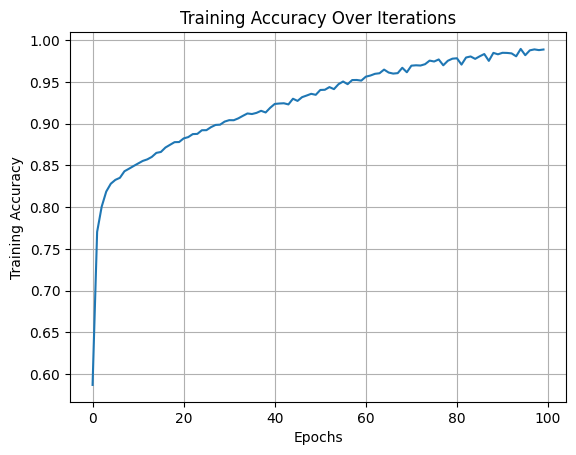

In [87]:
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Over Iterations')
plt.grid(True)
plt.show()

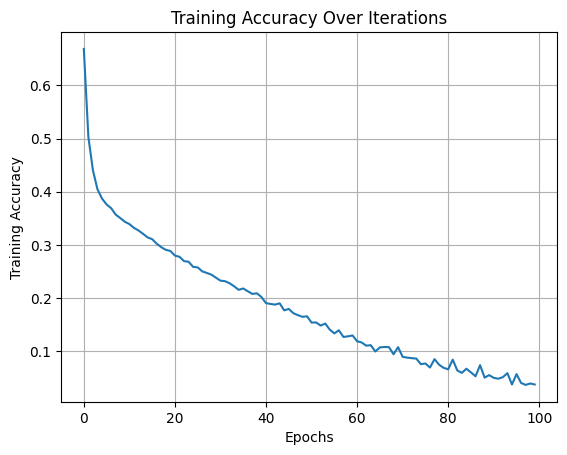

In [88]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Over Iterations')
plt.grid(True)
plt.show()

In [108]:
# prediction on test set
test_preds = []
all_labels = []

total_correct = 0
total_samples = 0

with torch.no_grad():
    for test_X, test_y in test_dataloader:
        test_X = test_X.to(device)
        test_y = test_y.to(device)

        test_pred = LSTM(test_X)
        test_predicted_classes = torch.argmax(test_pred, dim=1)

        # accuracy tracking
        total_correct += (test_predicted_classes == test_y).sum().item()
        total_samples += test_y.size(0)

        # save predictions and labels for analysis
        test_preds.extend(test_predicted_classes.cpu().numpy())
        all_labels.extend(test_y.cpu().numpy())

print(len(all_labels), len(test_preds))

9917 9917


In [ ]:
# Final accuracy
test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
LSTM_cm = confusion_matrix(all_labels, test_preds)
print("Confusion Matrix:\n", LSTM_cm)

# Classification Report
print("Classification Report:\n", classification_report(all_labels, test_preds))

Test Accuracy: 0.8693
Confusion Matrix:
 [[4110  829]
 [ 467 4511]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      4939
           1       0.84      0.91      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



### BERT

In [33]:
# checking for GPU availability
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")

2.7.1+cu126
12.6
90701
NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### Dataset prep

In [ ]:
# creating the dataset
ds = HFDataset.from_pandas(df, preserve_index=False)
ds = ds.train_test_split(test_size=0.2, seed=42)
ds = ds.rename_columns({
    "clean_review":"review"
})

ds

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 39665
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 9917
    })
})

In [35]:
# initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

At first I am going to use the tokenizer with truncation and compare it with one that doesn't truncate the results.

In [36]:
# defining the tokenizer function
def tokenizer128(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True, max_length = 128)
def tokenizer256(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True, max_length = 256)
def tokenizer512(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True)

In [37]:
def tokenize_and_split(examples, indices):
    result = tokenizer(
        examples["review"],
        truncation = True,
        padding = False,
        stride = 128,
        return_overflowing_tokens = True,
        return_attention_mask = True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
        result["original_index"] = [indices[i] for i in sample_map]
    return result

In [38]:
# Apply the tokenizer to the dataset
tokenized_dataset = ds.map(
                      tokenizer512, 
                      batched = True)
# Inspect tokenized samples
print(tokenized_dataset)

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map: 100%|██████████| 9917/9917 [00:02<00:00, 3739.90 examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 39665
    })
    test: Dataset({
        features: ['review', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9917
    })
})


#### Model selection and config

In [39]:
# initialize a Bert model for Binary classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

print(model.config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.53.2",
  "vocab_size": 30522
}



In [40]:
# Freeze all layers except the classifier
for param in model.distilbert.parameters():
    param.requires_grad = False
# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 592130


#### Training Pipeline

In [59]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy= "epoch",    # Saving strategy to match eval_strategy
    lr_scheduler_type="cosine",
    learning_rate=2e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True                        # Enable mixed precision for faster training
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [60]:
# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [61]:
# data collation for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [62]:
trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics,     # Custom metric
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.344900,0.335296,0.859040
2,0.346400,0.329158,0.861302
3,0.335200,0.326236,0.860055
4,0.315400,0.324907,0.860063
5,0.338600,0.325381,0.860517


TrainOutput(global_step=12400, training_loss=0.33476982532009003, metrics={'train_runtime': 1974.4161, 'train_samples_per_second': 100.447, 'train_steps_per_second': 6.28, 'total_flos': 2.62715968384512e+16, 'train_loss': 0.33476982532009003, 'epoch': 5.0})

#### Evaluating model

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5047
           1       0.86      0.86      0.86      4870

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



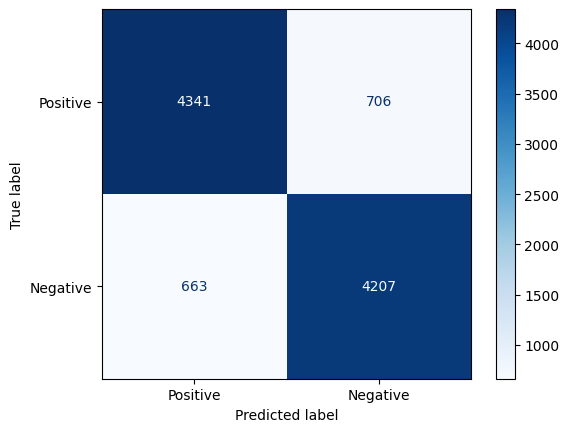

In [63]:
# Generate predictions
predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_dataset["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap = "Blues")

Error Analysis

In [65]:
# Error analysis
count = 0

for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_dataset["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(tokenized_dataset["test"][idx]["review"])
        count += 1
        if count == 5:
            break

Index: 1, Predicted: 1, Actual: 0
I saw this movie when it first came to the theaters in 1988 and though I knew it wasn t of award winning caliber I kinda liked it It tales the tale of 5 former cub scouts reuniting to take on the one task they never got to finish as kids which is to climb Mt Whitehead Of course now the cub scouts are all grown up and have developed their personalities in a variety of ways but none too differently than they were as children Richard Lewis is still neurotic Richard Belzer is still a playboy Franklyn Ajaye is still sort of the Dear Abby of the group and Tim Thomerson is still the surfer dude of the group Of course the top billed star is Louie Anderson a true believer in everything Cub Scout related He still lives in the same house with his mother still goes over the Cub Scout manual daily is brave reverent and clean and is the one who reunites the others for one more grand adventure in Scouting Compounding their task however is the Grunski brothers two bul

In [66]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

explainer = shap.Explainer(pipe)

shap_values = explainer(tokenized_dataset["test"]["review"][:5])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0])

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 6it [00:28,  5.76s/it]                       


#### Full fat DistillBert

In [67]:
# Freeze all layers except the classifier
for param in model.distilbert.parameters():
    param.requires_grad = True
# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 66955010


In [68]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.342500,0.330804,0.861523
2,0.346900,0.330783,0.861523
3,0.343200,0.330770,0.861523
4,0.315800,0.330763,0.861523
5,0.338500,0.330762,0.861523


TrainOutput(global_step=12400, training_loss=0.3339168131736017, metrics={'train_runtime': 43927.1783, 'train_samples_per_second': 4.515, 'train_steps_per_second': 0.282, 'total_flos': 2.62715968384512e+16, 'train_loss': 0.3339168131736017, 'epoch': 5.0})

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5047
           1       0.84      0.88      0.86      4870

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



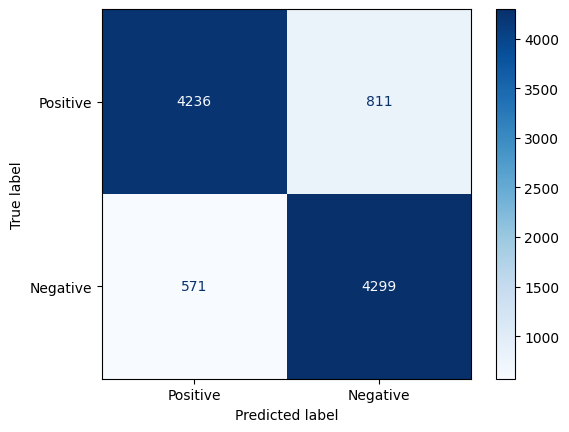

In [69]:
# Generate predictions
predictions = trainer.predict(tokenized_dataset["test"])
longformer_predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_dataset["test"]["label"], longformer_predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset["test"]["label"], longformer_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap = "Blues")

In [57]:
class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask = None, labels = None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output[1])  # Applying dropout
        logits = self.fc(pooled_output)  # Adding a fully connected layer

        # If labels are provided, calculate loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Initialize the custom model
custom_bert = CustomBERTModel("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

IndexError: tuple index out of range

In [ ]:
# Generate predictions
predictions = trainer.predict(tokenized_dataset["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(tokenized_dataset["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap = "Blues")